# Etapa 1 - instalando bibliotecas necessarias

In [ ]:
!pip install pandas
!pip install lxml
!pip install scikit-opt
!pip install igraph

# Etapa 2 - Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import time
# Import Operating System
import os

# Etapa 3 - Importando informações do espaco de estados do supremica.


In [2]:
### Etapa 3.1 Contém informações dos estados: Id, nome, initial and accepting.
df_states = pd.read_xml('Supervisor.xml',xpath=".//States//State",encoding='ISO-8859-1')

### Etapa 3.2 Contém informações dos eventos: Id, label and controllable.
df_events = pd.read_xml('Supervisor.xml',xpath=".//Events//Event",encoding='ISO-8859-1')

### Etapa 3.3 Contém informações das transições para cada estado : Id, source, dest and event.
df_transitions = pd.read_xml('Supervisor.xml',xpath=".//Transitions//Transition",encoding='ISO-8859-1')

# Etapa 4 - Fixando custo dos eventos 

In [3]:
#importando data frame com custo dos eventos
df_cost = pd.read_csv("Cost_events.csv");
df_cost["Cost"].tolist()

# inicializando lista com os custos dos eventos.
list_cost = df_cost["Cost"].tolist();

# inserindo os custos relativos a cada evento no dataframe de eventos.
df_events.insert(2,"cost",list_cost)


## Etapa 4.2 Criando um numpy array com as informacoes heuristicas de custo das arestas e um numpy array com identificador os eventos


In [4]:
# recebendo a quantidade de estados existentes no espaco de estados.
# e criando as duas matrizes, uma com informacao heuristica e outra com identificador dos eventos
x,y = df_states.shape

# inicializando array de custos
cost= np.full((x,x), -1,dtype=float);
transitions = np.full((x,x), -1,dtype=float);

In [5]:
# recebendo a quantidade de transições existentes no espaco de estados.
x,y = df_transitions.shape

# inserindo os valores de tempo para cada transição relativa ao seu estado, assim cada valor representa 
# uma transiçao existente entre o estado x(linha) com o estado y(coluna);
for i in range(x):
    cost[df_transitions.iloc[i,0],df_transitions.iloc[i,1]] = df_events.iloc[df_transitions.iloc[i,2],2];
    transitions[df_transitions.iloc[i,0],df_transitions.iloc[i,1]] = df_transitions.iloc[i,2];

# Etapa 5 - Fixando os parametros para o sistema de formigas.

In [6]:
#Informação heuristica das arestas vem do array cost, advindo da etapa 4.
#pegando as dimensoes do array cost para inicialização dos arrays tal e eta. 
x,y = cost.shape;

#feromonio presente nas arestas inicializado com 1, este parametro pode ser escolhido.
tal= np.full((x,y), 1,dtype=float);

#peso das arestas, calculado por meio da equação eta=1/time.
#elementos do array com -1 significa que não existe uma trasiçao entre os estados x(linha) e y(coluna).
eta= np.full((x,y), -1,dtype=float);
eta=1/cost;

In [7]:
##Inicialização dos parametros

#lista com estado inicial de alocação e lista com id das arestas de aceitação.
initial = df_states[df_states["initial"] == "true"]["id"].tolist();
acceptance = df_states[df_states["accepting"] == "true"]["id"].tolist();
# acceptance = [4,5,6,23,24,25];

#parâmetro que ajusta a importância do feromônio entre 0 a 1.
alpha = 0.42;

#parâmetro que ajusta a importância da informação heuristica entre 0 e 1;
beta=0.58;

#Numero de iteraçoes a ser realizadas
t=1000;

#numero de formigas na colônia.
k=43;

#quantidade de feromônio excretado por uma formiga a cada iteração.
Q=1;

#Taxa de evaporação do feromônio, p pode estar no intevalo entre 0 e 1;
P=0.37;

#quantidade de produtos a ser produzidos 
A = 44;
B = 36;

#  Etapa 6 - Sistema de formigas

In [8]:
def ant_sytem(t:int,k:int,Q:float,P:float, tal:np.array, eta:np.array, alpha:float, beta:float, transitions:np.array, initial:list, acceptance:list, A:int,
              B:int) -> list:
    """
        Parameters:              
            t           -> represents the number of iterations;
            k           -> represents the number of ants;
            tal         -> represents the amount of pheromone on the edges (x,y);
            eta         -> represents the heuristic information on the edges (x,y); 
            alpha       -> represents the pheromone importance parameter;
            beta        -> represents the heuristic importance parameter;
            states      -> represents the information DataFrame of each states, columns map (id_state, percorrido);
            transitions -> represents the information DataFrame of each transitions columns map (source, dest, event);
            initial     -> represents the initial allocation state;
            acceptance  -> represents the parameter (edges) of acceptance;

    """
    
    #Inicializacao das variaveis utilizadas
    #contagem do tempo
    my_time = 0;
    start = time.process_time();
    
    #Estado inicial de alocacao das formigas
    current_state = initial[0];
    
    #Rota da formiga Lk e sua distancia
    route_Lk = [];
    dist_Lk = []; 
    
    #Rota otima encontrada e sua distancia
    route_S = []
    dist_S = math.inf;
    
    #Variavel temporaria para guardar rota otima temporaria
    route_S_temp = []
    dist_S_temp = math.inf;
    
    #variaveis temporarias para guardar rota de estados e de transicoes
    Route_state = [];
    Route_transitions = [];
    
    #variavel que contem o rastro de feromonio das formigas
    pheromone_trail = np.full(tal.shape, 0,dtype=float);

    #variavel para guardar dados para plot do grafico
    #Variavel para guardar o custo das formigas em cada iteracao
    chart_dist_ls = [];
    #varivavel para guardar o custo de cada rota construida por iteracao
    chart_dist_s = [];
    
    #numero de iteracoes a ser realizadas, apos uma condicao de parada ser atingida, retorna a rota otima.
    for i in range(t):

        #Constroi as rotas das k formigas da colonia.
        for ant in range(k):
            
            #faz o calculo de uma rota para uma formiga, retorna a rota da formiga K
            Route_state, Route_transitions = Ant(tal,eta,alpha,beta,transitions,initial,acceptance,A,B)
            
            #validar o retorno, caso deu erro na rota da formiga, nao adiciona ela
            if(Route_state[0] != -1):
                
                route_Lk.append(Route_state);

                #calcula o tamanho da rota encontrada
                dist_Lk.append(route_lk_calculation(route_Lk[ant]));

                #Calcular o rastro deixado pela formiga k:
                #  pheromone = Q/dist_lk;
                pheromone_trail_calculation(Q,dist_Lk[ant],route_Lk[ant],pheromone_trail);

                #atualiza a melhor rota encontrada pelas formigas ate o momento
                if(dist_Lk[ant] < dist_S_temp):
                    route_S_temp = route_Lk[ant];
                    dist_S_temp = dist_Lk[ant];
                    
        #após construir uma rota, atualizamos o feromonio e a evaporacao
        tal = pheromone_update(P,tal,pheromone_trail,route_S);
     
        #Atualiza o grafico das formigas
        chart_dist_ls.append(dist_Lk);    

        #Atualiza o grafico de iteraçoes   
        chart_dist_s.append(dist_S_temp);
                
        #Atualiza melhor rota global ate o momento
        if(dist_S_temp < dist_S):
            route_S = route_S_temp;
            dist_S = dist_S_temp;
 

        #finaliza a contagem do tempo de iteraçao
        end = time.process_time();
        my_time += (end - start);

        #condicao de parada do algoritmo, para pelo tempo definido ou numero de interacoes
        if(my_time > 180 or i > 50):

            print("Melhor custo de produção encontrado:",dist_S)
            return route_S,chart_dist_ls,chart_dist_s;
        
        #se condicao de parada nao atingida busca uma nova solução
        start = time.process_time();

        #resetando variaveis das formigas para proxima iteracao
        route_Lk = [];
        dist_Lk = [];
        route_S_temp = []
        dist_S_temp = math.inf;
        pheromone_trail = np.full(tal.shape, 0,dtype=float);

In [9]:
def Ant(tal:np.array, eta:np.array, alpha:float, beta:float, transitions:np.array, initial:list, acceptance:list,A:int,B:int) -> list:
    """
        Parameters:              
            tal         -> represents the amount of pheromone on the edges (x,y);
            eta         -> represents the heuristic information on the edges (x,y); 
            alpha       -> represents the pheromone importance parameter;
            beta        -> represents the heuristic importance parameter;
            states      -> represents the information DataFrame of each states, columns map (id_state, percorrido);
            transitions -> represents the information DataFrame of each transitions columns map (source, dest, event);
            initial     -> represents the initial allocation state;
            acceptance  -> represents the acceptance state;
    """
    
    #inicia variaveis
    
    current_state = initial[0];
    next_state=-1;
    current_transition = -1;
    Route_state = [];
    Route_transitions = [];
    
    Route_state.append(current_state);
    
    #Comentado pois nao vou ver quais sao os estados, vou salvar o id das transicoes
    #Route.append(current_state);
    
    #Variaveis de desgaste para fazer manutencao
    M1 = 0.1;
    M2 = 0.1;
    
    # lista com eventos proibidos de serem escolhidos
    tabu_list = []
    
    #lista de eventos de todos os eventos exceto os de suporte e manutencao
    all_event_R1 = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16];
    all_event_R2 = [19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35];

    #faz o calculo de uma rota para a formiga k
    #Faz o repetir o loop de criar rotas ate que se encontre o objetivo
    accepted = True;
    
    error = [-1];
    
    my_time = 0;
    start = time.process_time();
    
    while(accepted):
        #para cada aresta do estado atual, 
        #calculamos a probabilidade de transicao para proximos estados 
        dict_propability = probability_calculation(tal, eta, alpha, beta, current_state, transitions,tabu_list,M1,M2);
        #print("Probabilidades das transicoes")
        #print(dict_propability);

        #o resultado da roleta é o estado que vai ser transitado
        next_state = roulette(dict_propability);
        if(next_state == None):
            print("Estado escolhido para transitar",next_state)
        #print(next_state);

        #encontrar qual evento em transitions faz sair de current_state e vai para estado retornado da roleta.
        current_transition = transitions[current_state,next_state];

        #add na route o id da transicao do estado current_state para estado next_state.
        Route_transitions.append(current_transition);        
            
        #add na route o estado que vai ser transitado, do estado current_state vai para estado next_state.
        Route_state.append(next_state);
        
        #avança para o novo estado escolhido.
        current_state = next_state;

        #verifica a condicao de parada, caso tenha encontrado a quantidade desejada de arestas
        #verifica se eventos de manutencao ocorreram, entao reduz o coeficiente de reforco
        if(4 == current_transition):
            M1 = 0.1;
            tabu_list = list(set(tabu_list) - set(all_event_R1));

        elif(23 == current_transition):
            M2 = 0.1;
            tabu_list = list( set(tabu_list) - set(all_event_R2)  );
            
        #verifica o evento de produçao, contabilizando um produto e aumentando o 
        #desgaste (coeficiente de reforco de manutencao)
        elif(5 == current_transition):
            A-= 1;
            M1+=0.4;

        elif(6 == current_transition):
            B-=1;
            M1+=0.4;

        elif(24 == current_transition):
            A-= 1;
            M2+=0.4;

        elif(25 == current_transition):
            B-=1;
            M2+=0.4;
            
        if(M1 > 2):
            tabu_list = list(set(tabu_list) | set(all_event_R1));
             
        if(M2 > 2):
            tabu_list = list(set(tabu_list) | set(all_event_R2));
         
        end = time.process_time();
        my_time += (end - start);
        
        if(A <= 0 and B <= 0):
            accepted = False;
        elif(my_time > 30):
            return error, error;
        
        start = time.process_time();
                
    return Route_state, Route_transitions;

In [10]:
def pheromone_update(P:float, tal:np.array, pheromone:np.array, route_S:list) -> np.array:
#deposita feromônio de todas as formigas que passaram sobre as arestas;
#evita o acumulo infinito de feromônios nas arestas por meio da evaporação;
   
    #acho que tem que verificar se a rota nao repete arestas, para nao incluir duas vezes feromonio.    
    tam = len(route_S);
    tal = (1-P)*(tal);
    
    for i in range(tam):
        if(i < tam-1):  
            tal[route_S[i],route_S[i+1]] = round(tal[route_S[i],route_S[i+1]] + pheromone[route_S[i],route_S[i+1]],10);
            
    return tal;

In [11]:
def pheromone_trail_calculation(Q:float, dist_Lk:float, route_Lk:list, pheromone:np.array):

    pheromone_excreted = round(Q/dist_Lk,10);
    tam = len(route_Lk);
    
    for i in range(tam):
        if(i < tam-1):
            pheromone[route_Lk[i],route_Lk[i+1]] += pheromone_excreted;
            
     

In [12]:
def route_lk_calculation(route_Lk:list) -> float:
   
    dist = 0;
    tam = len(route_Lk);

    for i in range(tam):

        if(i < tam-1):            
            dist += (1 / float(eta[route_Lk[i],route_Lk[i+1]]) );
            
    return round(dist,4) ;

In [13]:
#realiza o cálculo das probabilidades de escolha de cada aresta;
#remover do calculo as transicoes que levam a estados ja percorridos
def probability_calculation(tal:np.array, eta:np.array, alpha:float, beta:float, current_state:int,
                            transitions:np.array, black_list:list,coef_m1:float,coef_m2:float) -> dict:
    
    
    #criar um coeficiente de manutencao para os dois robôs, verificar se a aresta do nó
    #é um evento de manutencao, entao aplicar o valor do coeficiente, no final da conta o evento volta a ser
    #neutro, ou seja igual a 1.
    #Aplicar a mesma logica para os eventos de support que levam a manutencao
    
    
    # pega as dimensoes da tabela eta;   
    x,y = eta.shape;
    probabilidades ={};
    numerador = {};
    denominador = 0;
    keys = [];
    block = 1;
    reinforcement_effect = 1.0;
    calc_int = 0;
    
    #eventos de  suport, suport_end e maintenance
    list_support_B1 = [4,17,18];
    list_support_B2 = [23,36,37];
    
    for i in range(y):
        
        if(eta[current_state, i] != -1):
            #verifica se é um evento de manutencao para alterar o coeficiente de reforco
            for k in list_support_B1:
                if(transitions[current_state, i] == k):
                    reinforcement_effect = coef_m1;

            for k in list_support_B2:
                if(transitions[current_state, i] == k):
                    reinforcement_effect = coef_m2;                    
    
            #verifica se o evento esta na lista tabu, e exclui da conta.
            for j in black_list:
                if(transitions[current_state, i] == j):
                    block = -1;
                
            if(block != -1):
                numerador[i] = reinforcement_effect * ((tal[current_state, i])**alpha) * ((eta[current_state, i])**beta);
                denominador += numerador[i];
                keys.append(i);
                
        block = 1;
        reinforcement_effect = 1.0;

    for i in keys:
        #transforma a probabilidade em um numero entre 0 e 10000;
        calc_int = round((numerador[i]/denominador),4);
        calc_int *= 10000;

        if(calc_int > 0):
            calc_int = int(calc_int);
            probabilidades[i] = calc_int;
    
    return probabilidades;

In [14]:
#roleta viciada para escolha da aresta;
def roulette(dict_propability:dict) -> int:
    n = random.randint(1,9999);
    save=-1;
    acumulador = 0;
    
    for i in dict_propability.items():
        acumulador+= i[1];
        save=i[0];
        if(n <= acumulador):
            return i[0];

    return save;
    

In [15]:
def plot_iterations(chart_dist_s:list,  **kwargs):
    
    title = kwargs.get('title')
    size = kwargs.get('size')
    fig1, axs1= plt.subplots(1,figsize=size);
    

    axs1.plot(range(len(chart_dist_s)), chart_dist_s)
    axs1.set_title(title[0]);
    axs1.set_xlabel('Numero de iterações');
    axs1.set_ylabel('Custo da solução');
    axs1.grid(True);


Melhor custo de produção encontrado: 10628.0


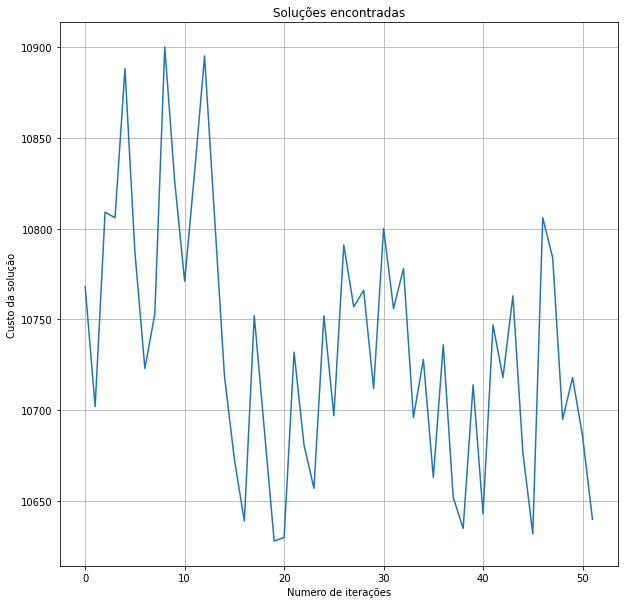

In [16]:
route_S_1,chart_dist_ls_1,chart_dist_s_1 = ant_sytem(t,k,Q,P, tal, eta, alpha, beta,transitions, initial, acceptance,A,B);

plot_iterations(chart_dist_s_1, title = ["Soluções encontradas"], size = (10,10))

#  Etapa 7 - Resultado encontrado pelo algoritmo

In [18]:
ROUTE = route_S_1;

robo1A = 0
robo1B = 0
robo2A = 0
robo2B = 0
Eventos = [];

for i in range(len(ROUTE)):
    if(i < len(ROUTE)-1):
        
        label = df_events.loc[df_events["id"] == transitions[ROUTE[i],ROUTE[i+1]],["label"]].values[0,0]
        Eventos.append(label);

        if(label == "B1_POINT_OF_INTEREST_FIN_A"):
            robo1A+= 1;
        elif(label == "B1_POINT_OF_INTEREST_FIN_B"):
            robo1B+= 1;
        elif(label == "B2_POINT_OF_INTEREST_FIN_A"):
            robo2A+= 1;
        elif(label == "B2_POINT_OF_INTEREST_FIN_B"):
            robo2B+= 1;
        
        print(label)
        
#print(Eventos);
print("Pecas A feitas pelo robô 1",robo1A)
print("Pecas B feitas pelo robô 1",robo1B)
print("Pecas A feitas pelo robô 2",robo2A)
print("Pecas B feitas pelo robô 2",robo2B)
    

B2_PRE
B2_PRE_END
B2_PREPARATION_B
B2_POINT_OF_INTEREST_PRE_B
B2_FIN_B
B2_FIN_B_END
B1_PRE
B2_POINT_OF_INTEREST_FIN_B
B2_STOP
B1_PRE_END
B1_PREPARATION_B
B1_POINT_OF_INTEREST_PRE_B
B2_STOP_END
B1_FIN_B
B1_FIN_B_END
B1_POINT_OF_INTEREST_FIN_B
B2_PRE
B1_STOP
B2_PRE_END
B2_PREPARATION_B
B2_POINT_OF_INTEREST_PRE_B
B1_STOP_END
B2_FIN_B
B2_FIN_B_END
B1_PRE
B1_PRE_END
B1_PREPARATION_B
B1_POINT_OF_INTEREST_PRE_B
B2_POINT_OF_INTEREST_FIN_B
B2_STOP
B2_STOP_END
B1_FIN_B
B1_FIN_B_END
B2_PRE
B2_PRE_END
B2_PREPARATION_B
B2_POINT_OF_INTEREST_PRE_B
B1_POINT_OF_INTEREST_FIN_B
B1_STOP
B1_STOP_END
B2_FIN_B
B2_FIN_B_END
B1_PRE
B1_PRE_END
B1_PREPARATION_A
B1_POINT_OF_INTEREST_PRE_A
B2_POINT_OF_INTEREST_FIN_B
B2_SUPPORT
B2_SUPPORT_END
B1_FIN_A
B2_MAINTENANCE
B1_FIN_A_END
B2_PRE
B2_PRE_END
B2_PREPARATION_B
B2_POINT_OF_INTEREST_PRE_B
B1_POINT_OF_INTEREST_FIN_A
B1_SUPPORT
B1_SUPPORT_END
B2_FIN_B
B2_FIN_B_END
B2_POINT_OF_INTEREST_FIN_B
B2_PRE_B
B2_PRE_END
B2_PREPARATION_B
B2_POINT_OF_INTEREST_PRE_B
B2_FIN_B
B1_